In [170]:
from web3 import Web3
from dotenv import load_dotenv
from hexbytes import HexBytes
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [171]:
load_dotenv()

INFURA_KEY = os.environ.get('INFURA_KEY')
DUNE_KEY = os.environ.get('DUNE_KEY')

last_epoch = 6

## Helper functions

In [172]:
def get_contract(blockchain, contract_address, abi):
    rpc_url = f'https://{blockchain}.infura.io/v3/{INFURA_KEY}'
    w3 = Web3(Web3.HTTPProvider(rpc_url))
    contract = w3.eth.contract(address=contract_address, abi=abi)
    return contract

In [173]:
def plot(df, group_column, sum_column, title, xlabel, ylabel): # Plot 
    # Group by stakeDuration and sum the rewards
    result = df.groupby(group_column)[sum_column].sum().reset_index()
    
    # Ensure all stakeDurations from 0 to 4 years are present
    all_stakeDurations = pd.DataFrame({group_column: range(5)})
    result = all_stakeDurations.merge(result, on=group_column, how='left').fillna(0)
    
    # Sort by stakeDuration and ensure integer type
    result_sorted = result.sort_values(group_column)
    result_sorted[sum_column] = result_sorted[sum_column].astype(int)
    
    # Set up the plot style
    plt.style.use('ggplot')
    
    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create the bar plot
    bars = ax.bar(result_sorted[group_column], result_sorted[sum_column])
    
    # Customize the plot
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,}',
                ha='center', va='bottom')
    
    # Set x-axis ticks to show only integer years
    ax.set_xticks(range(5))
    ax.set_xticklabels(range(5))
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

## Maverick Reward Contracts associated to each Boosted Positions

In [174]:
# Because of the contract change at epoch 3, need to split contract 
# addresses between "new" (after epoch 3) and "old" (before epoch 3), 
# and get the data for both contracts.

MaverickV2RewardFactory_contract_addresses = [
    ['new', 'arbitrum-mainnet', '0x873b272D7493Da5860E9c513cB805Ff3287D8470'],
    ['new', 'base-mainnet', '0x1cdC67950a68256c5157987bBF700e94595807F8'],
    ['new', 'mainnet', '0x63EF1a657cc53747689B201aa07A76E9ef22f8Fe'],
    # Not including BSC & Scroll as explained in the Scope & Assumptions section
    #['new', 'bsc-mainnet', '0x443b1F86D45C1dDC60b355D5A8A931656aB25267'], 
    ['new', 'zksync-mainnet', '0xc9e5F0832C96F8E2EEDe472C1B87621Cbb86D7e0'],
    #['new', 'scroll-mainnet', '0x873b272D7493Da5860E9c513cB805Ff3287D8470'],
    ['old', 'arbitrum-mainnet', '0x353904E4AFDa57E8c4353a2Eb173e566D8dF826C'],
    ['old','base-mainnet', '0x3fa57C30fF8B13f84817416CD748B2260Ce40B9A'],
    ['old','mainnet', '0x37232785ACD3EADdfd784dB3f9eCc1f8bcBd7eC7'],
    #['old','bsc-mainnet', '0x7573B601B2E4e0cDC8fbaA328e08e733C697c565'],
    ['old','zksync-mainnet', '0xdb7168fe2f3c1C3B400337ac0BDeDb9b193775F9'],
]

MaverickV2RewardFactory_abis = {
        'new': 
            '[{"inputs":[{"internalType":"contract IMaverickV2BoostedPositionFactory","name":"boostedPositionFactory_","type":"address"},{"internalType":"contract IMaverickV2VotingEscrowFactory","name":"votingEscrowFactory_","type":"address"}],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[],"name":"RewardFactoryInvalidVeBaseTokenPair","type":"error"},{"inputs":[],"name":"RewardFactoryNotFactoryBoostedPosition","type":"error"},{"inputs":[],"name":"RewardFactoryRewardAndVeLengthsAreNotEqual","type":"error"},{"inputs":[{"internalType":"uint256","name":"index","type":"uint256"},{"internalType":"contract IERC20","name":"lastRewardToken","type":"address"},{"internalType":"contract IERC20","name":"rewardToken","type":"address"}],"name":"RewardFactoryTokensNotSorted","type":"error"},{"inputs":[],"name":"RewardFactoryTooManyRewardTokens","type":"error"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"contract IERC20","name":"stakeToken","type":"address"},{"indexed":false,"internalType":"contract IERC20[]","name":"rewardTokens","type":"address[]"},{"indexed":false,"internalType":"contract IMaverickV2VotingEscrow[]","name":"veTokens","type":"address[]"},{"indexed":false,"internalType":"contract IMaverickV2Reward","name":"rewardsContract","type":"address"},{"indexed":false,"internalType":"bool","name":"isFactoryBoostedPosition","type":"bool"}],"name":"CreateRewardsContract","type":"event"},{"inputs":[],"name":"boostedPositionFactory","outputs":[{"internalType":"contract IMaverickV2BoostedPositionFactory","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"startIndex","type":"uint256"},{"internalType":"uint256","name":"endIndex","type":"uint256"}],"name":"boostedPositionRewards","outputs":[{"internalType":"contract IMaverickV2Reward[]","name":"","type":"address[]"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"boostedPositionRewardsCount","outputs":[{"internalType":"uint256","name":"count","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IERC20","name":"stakeToken","type":"address"},{"internalType":"contract IERC20[]","name":"rewardTokens","type":"address[]"},{"internalType":"contract IMaverickV2VotingEscrow[]","name":"veTokens","type":"address[]"}],"name":"createRewardsContract","outputs":[{"internalType":"contract IMaverickV2Reward","name":"rewardsContract","type":"address"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"","type":"address"}],"name":"isFactoryContract","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"startIndex","type":"uint256"},{"internalType":"uint256","name":"endIndex","type":"uint256"}],"name":"nonBoostedPositionRewards","outputs":[{"internalType":"contract IMaverickV2Reward[]","name":"","type":"address[]"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"nonBoostedPositionRewardsCount","outputs":[{"internalType":"uint256","name":"count","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"startIndex","type":"uint256"},{"internalType":"uint256","name":"endIndex","type":"uint256"}],"name":"rewards","outputs":[{"internalType":"contract IMaverickV2Reward[]","name":"","type":"address[]"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"rewardsCount","outputs":[{"internalType":"uint256","name":"count","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IERC20","name":"stakeToken","type":"address"},{"internalType":"uint256","name":"startIndex","type":"uint256"},{"internalType":"uint256","name":"endIndex","type":"uint256"}],"name":"rewardsForStakeToken","outputs":[{"internalType":"contract IMaverickV2Reward[]","name":"","type":"address[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IERC20","name":"stakeToken","type":"address"}],"name":"rewardsForStakeTokenCount","outputs":[{"internalType":"uint256","name":"count","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"votingEscrowFactory","outputs":[{"internalType":"contract IMaverickV2VotingEscrowFactory","name":"","type":"address"}],"stateMutability":"view","type":"function"}]'
        , 
        'old':
            '[{"inputs":[{"internalType":"contract IMaverickV2BoostedPositionFactory","name":"boostedPositionFactory_","type":"address"},{"internalType":"contract IMaverickV2VotingEscrowFactory","name":"votingEscrowFactory_","type":"address"}],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[],"name":"RewardFactoryInvalidVeBaseTokenPair","type":"error"},{"inputs":[],"name":"RewardFactoryNotFactoryBoostedPosition","type":"error"},{"inputs":[],"name":"RewardFactoryRewardAndVeLengthsAreNotEqual","type":"error"},{"inputs":[],"name":"RewardFactoryTooManyRewardTokens","type":"error"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"contract IERC20","name":"stakeToken","type":"address"},{"indexed":false,"internalType":"contract IERC20[]","name":"rewardTokens","type":"address[]"},{"indexed":false,"internalType":"contract IMaverickV2VotingEscrow[]","name":"veTokens","type":"address[]"},{"indexed":false,"internalType":"contract IMaverickV2Reward","name":"rewardsContract","type":"address"},{"indexed":false,"internalType":"bool","name":"isFactoryBoostedPosition","type":"bool"}],"name":"CreateRewardsContract","type":"event"},{"inputs":[],"name":"boostedPositionFactory","outputs":[{"internalType":"contract IMaverickV2BoostedPositionFactory","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"startIndex","type":"uint256"},{"internalType":"uint256","name":"endIndex","type":"uint256"}],"name":"boostedPositionRewards","outputs":[{"internalType":"contract IMaverickV2Reward[]","name":"","type":"address[]"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"boostedPositionRewardsCount","outputs":[{"internalType":"uint256","name":"count","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IERC20","name":"stakeToken","type":"address"},{"internalType":"contract IERC20[]","name":"rewardTokens","type":"address[]"},{"internalType":"contract IMaverickV2VotingEscrow[]","name":"veTokens","type":"address[]"}],"name":"createRewardsContract","outputs":[{"internalType":"contract IMaverickV2Reward","name":"rewardsContract","type":"address"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"","type":"address"}],"name":"isFactoryContract","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"startIndex","type":"uint256"},{"internalType":"uint256","name":"endIndex","type":"uint256"}],"name":"nonBoostedPositionRewards","outputs":[{"internalType":"contract IMaverickV2Reward[]","name":"","type":"address[]"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"nonBoostedPositionRewardsCount","outputs":[{"internalType":"uint256","name":"count","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"startIndex","type":"uint256"},{"internalType":"uint256","name":"endIndex","type":"uint256"}],"name":"rewards","outputs":[{"internalType":"contract IMaverickV2Reward[]","name":"","type":"address[]"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"rewardsCount","outputs":[{"internalType":"uint256","name":"count","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IERC20","name":"stakeToken","type":"address"},{"internalType":"uint256","name":"startIndex","type":"uint256"},{"internalType":"uint256","name":"endIndex","type":"uint256"}],"name":"rewardsForStakeToken","outputs":[{"internalType":"contract IMaverickV2Reward[]","name":"","type":"address[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IERC20","name":"stakeToken","type":"address"}],"name":"rewardsForStakeTokenCount","outputs":[{"internalType":"uint256","name":"count","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"votingEscrowFactory","outputs":[{"internalType":"contract IMaverickV2VotingEscrowFactory","name":"","type":"address"}],"stateMutability":"view","type":"function"}]'
       }

MaverickV2RewardFactory_values = []

for contract_address_ in MaverickV2RewardFactory_contract_addresses:
    old_new = contract_address_[0]
    blockchain = contract_address_[1]
    contract_address = contract_address_[2]
    abi = MaverickV2RewardFactory_abis[old_new]

    contract = get_contract(blockchain, contract_address, abi)
    print(old_new + ' - ' + blockchain)
    logs = contract.events.CreateRewardsContract().get_logs(fromBlock=1)
    for log in logs:
        MaverickV2RewardFactory_values.append({'blockchain': blockchain
            , 'old_new': old_new
            , 'rewardsContract': log['args']['rewardsContract']
            , 'boostedPosition': log['args']['stakeToken']
            }
        )
        

new - arbitrum-mainnet
new - base-mainnet
new - mainnet
new - zksync-mainnet
old - arbitrum-mainnet
old - base-mainnet
old - mainnet
old - zksync-mainnet


In [175]:
MaverickV2RewardFactory_df = pd.DataFrame(MaverickV2RewardFactory_values)
MaverickV2RewardFactory_df.head()

,blockchain,old_new,rewardsContract,boostedPosition
0,arbitrum-mainnet,new,0xf9Cf0924b14e9Cd6C45Fb8AD64D2eea61Fe3DB31,0x9789983F5007d382F1f8e2c21470aEad17387d80
1,arbitrum-mainnet,new,0xa58cAB419Fd595A2a5616da7b74De5Eacb30FB18,0xA812dD1B0B5De5C3121708afB974650f86d582d4
2,arbitrum-mainnet,new,0x9f4781fC065e2052E75127D4f5D270e2Bb861989,0x80c1Bce70cc766D81A6b663D006f5634e3aA7521
3,arbitrum-mainnet,new,0xcaf615710c70EB6E79279B4dAB424B6D8Ef92587,0xfE984709890EF3c2B630a4e71222B9140e9888F6
4,arbitrum-mainnet,new,0x01546c49Efd87964F39248B5E18fA4806f3A1FA8,0x9E40E1487bB689ABF7626DA86EFDF2092eDDf77e


## Claimed Rewards by stakeDuration (with GetReward() events)

In [176]:
MaverickV2Reward_values = []

MaverickV2Reward_abis = {
    'new': '[{"inputs":[{"internalType":"string","name":"name_","type":"string"},{"internalType":"string","name":"symbol_","type":"string"},{"internalType":"contract IERC20","name":"_stakingToken","type":"address"},{"internalType":"contract IERC20[]","name":"rewardTokens","type":"address[]"},{"internalType":"contract IMaverickV2VotingEscrow[]","name":"veTokens","type":"address[]"}],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[{"internalType":"address","name":"target","type":"address"}],"name":"AddressEmptyCode","type":"error"},{"inputs":[{"internalType":"address","name":"account","type":"address"}],"name":"AddressInsufficientBalance","type":"error"},{"inputs":[],"name":"ERC721EnumerableForbiddenBatchMint","type":"error"},{"inputs":[{"internalType":"address","name":"sender","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"address","name":"owner","type":"address"}],"name":"ERC721IncorrectOwner","type":"error"},{"inputs":[{"internalType":"address","name":"operator","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"ERC721InsufficientApproval","type":"error"},{"inputs":[{"internalType":"address","name":"approver","type":"address"}],"name":"ERC721InvalidApprover","type":"error"},{"inputs":[{"internalType":"address","name":"operator","type":"address"}],"name":"ERC721InvalidOperator","type":"error"},{"inputs":[{"internalType":"address","name":"owner","type":"address"}],"name":"ERC721InvalidOwner","type":"error"},{"inputs":[{"internalType":"address","name":"receiver","type":"address"}],"name":"ERC721InvalidReceiver","type":"error"},{"inputs":[{"internalType":"address","name":"sender","type":"address"}],"name":"ERC721InvalidSender","type":"error"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"ERC721NonexistentToken","type":"error"},{"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"uint256","name":"index","type":"uint256"}],"name":"ERC721OutOfBoundsIndex","type":"error"},{"inputs":[],"name":"FailedInnerCall","type":"error"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"uint256","name":"currentBalance","type":"uint256"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"InsufficientBalance","type":"error"},{"inputs":[],"name":"MathOverflowedMulDiv","type":"error"},{"inputs":[],"name":"ReentrancyGuardReentrantCall","type":"error"},{"inputs":[{"internalType":"uint256","name":"duration","type":"uint256"},{"internalType":"uint256","name":"minDuration","type":"uint256"},{"internalType":"uint256","name":"maxDuration","type":"uint256"}],"name":"RewardDurationOutOfBounds","type":"error"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"address","name":"approved","type":"address"},{"internalType":"address","name":"getter","type":"address"}],"name":"RewardNotApprovedGetter","type":"error"},{"inputs":[{"internalType":"uint8","name":"index","type":"uint8"}],"name":"RewardNotValidIndex","type":"error"},{"inputs":[{"internalType":"contract IERC20","name":"rewardTokenAddress","type":"address"}],"name":"RewardNotValidRewardToken","type":"error"},{"inputs":[{"internalType":"contract IERC20","name":"stakingToken","type":"address"}],"name":"RewardTokenCannotBeStakingToken","type":"error"},{"inputs":[],"name":"RewardTransferNotSupported","type":"error"},{"inputs":[{"internalType":"uint256","name":"timestamp","type":"uint256"},{"internalType":"uint256","name":"minTimestamp","type":"uint256"}],"name":"RewardUnboostedTimePeriodNotMet","type":"error"},{"inputs":[],"name":"RewardZeroAmount","type":"error"},{"inputs":[{"internalType":"uint8","name":"bits","type":"uint8"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"SafeCastOverflowedUintDowncast","type":"error"},{"inputs":[{"internalType":"address","name":"token","type":"address"}],"name":"SafeERC20FailedOperation","type":"error"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"contract IERC20","name":"rewardTokenAddress","type":"address"},{"indexed":false,"internalType":"uint8","name":"rewardTokenIndex","type":"uint8"}],"name":"AddRewardToken","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"approved","type":"address"},{"indexed":true,"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"operator","type":"address"},{"indexed":false,"internalType":"bool","name":"approved","type":"bool"}],"name":"ApprovalForAll","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"tokenId","type":"uint256"},{"indexed":false,"internalType":"address","name":"getter","type":"address"}],"name":"ApproveRewardGetter","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"tokenId","type":"uint256"},{"indexed":false,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"uint8","name":"rewardTokenIndex","type":"uint8"},{"indexed":false,"internalType":"uint256","name":"stakeDuration","type":"uint256"},{"indexed":false,"internalType":"contract IERC20","name":"rewardTokenAddress","type":"address"},{"components":[{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"bool","name":"asVe","type":"bool"},{"internalType":"contract IMaverickV2VotingEscrow","name":"veContract","type":"address"}],"indexed":false,"internalType":"struct IMaverickV2Reward.RewardOutput","name":"rewardOutput","type":"tuple"},{"indexed":false,"internalType":"uint256","name":"lockupId","type":"uint256"}],"name":"GetReward","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"contract IERC20","name":"rewardTokenAddress","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"duration","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"rewardRate","type":"uint256"}],"name":"NotifyRewardAmount","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"contract IERC20","name":"rewardTokenAddress","type":"address"},{"indexed":false,"internalType":"uint8","name":"rewardTokenIndex","type":"uint8"}],"name":"RemoveRewardToken","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"address","name":"supplier","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"tokenId","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"userBalance","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"totalSupply","type":"uint256"}],"name":"Stake","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"from","type":"address"},{"indexed":true,"internalType":"address","name":"to","type":"address"},{"indexed":true,"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"Transfer","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"tokenId","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"},{"indexed":false,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"uint256","name":"userBalance","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"totalSupply","type":"uint256"}],"name":"UnStake","type":"event"},{"inputs":[],"name":"MAX_DURATION","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"MIN_DURATION","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"UNBOOSTED_MIN_TIME_GAP","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"approve","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"}],"name":"balanceOf","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"contract IMaverickV2VotingEscrow","name":"veToken","type":"address"},{"internalType":"uint256","name":"rawAmount","type":"uint256"},{"internalType":"uint256","name":"stakeDuration","type":"uint256"}],"name":"boostedAmount","outputs":[{"internalType":"uint256","name":"earnedAmount","type":"uint256"},{"internalType":"bool","name":"asVe","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"checkAuthorized","outputs":[{"internalType":"address","name":"owner","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"contractInfo","outputs":[{"components":[{"internalType":"uint256","name":"finishAt","type":"uint256"},{"internalType":"uint256","name":"updatedAt","type":"uint256"},{"internalType":"uint256","name":"rewardRate","type":"uint256"},{"internalType":"uint256","name":"escrowedReward","type":"uint256"},{"internalType":"uint256","name":"rewardPerTokenStored","type":"uint256"},{"internalType":"contract IERC20","name":"rewardToken","type":"address"},{"internalType":"contract IMaverickV2VotingEscrow","name":"veRewardToken","type":"address"},{"internalType":"uint128","name":"unboostedAmount","type":"uint128"},{"internalType":"uint256","name":"lastUnboostedPushTimestamp","type":"uint256"}],"internalType":"struct IMaverickV2Reward.RewardInfo[]","name":"info","type":"tuple[]"},{"components":[{"internalType":"string","name":"name","type":"string"},{"internalType":"string","name":"symbol","type":"string"},{"internalType":"uint256","name":"totalSupply","type":"uint256"},{"internalType":"contract IERC20","name":"stakingToken","type":"address"}],"internalType":"struct IMaverickV2Reward.ContractInfo","name":"_contractInfo","type":"tuple"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"earned","outputs":[{"components":[{"internalType":"uint256","name":"earned","type":"uint256"},{"internalType":"contract IERC20","name":"rewardToken","type":"address"}],"internalType":"struct IMaverickV2Reward.EarnedInfo[]","name":"earnedInfo","type":"tuple[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"contract IERC20","name":"rewardTokenAddress","type":"address"}],"name":"earned","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"getApproved","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint8","name":"rewardTokenIndex","type":"uint8"},{"internalType":"uint256","name":"stakeDuration","type":"uint256"}],"name":"getReward","outputs":[{"components":[{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"bool","name":"asVe","type":"bool"},{"internalType":"contract IMaverickV2VotingEscrow","name":"veContract","type":"address"}],"internalType":"struct IMaverickV2Reward.RewardOutput","name":"","type":"tuple"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"uint8","name":"rewardTokenIndex","type":"uint8"},{"internalType":"uint256","name":"stakeDuration","type":"uint256"}],"name":"getRewardToOwner","outputs":[{"components":[{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"bool","name":"asVe","type":"bool"},{"internalType":"contract IMaverickV2VotingEscrow","name":"veContract","type":"address"}],"internalType":"struct IMaverickV2Reward.RewardOutput","name":"","type":"tuple"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"uint8","name":"rewardTokenIndex","type":"uint8"},{"internalType":"uint256","name":"stakeDuration","type":"uint256"},{"internalType":"uint256","name":"lockupId","type":"uint256"}],"name":"getRewardToOwnerForExistingVeLockup","outputs":[{"components":[{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"bool","name":"asVe","type":"bool"},{"internalType":"contract IMaverickV2VotingEscrow","name":"veContract","type":"address"}],"internalType":"struct IMaverickV2Reward.RewardOutput","name":"","type":"tuple"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"address","name":"operator","type":"address"}],"name":"isApprovedForAll","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"}],"name":"mint","outputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"mintToSender","outputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes[]","name":"data","type":"bytes[]"}],"name":"multicall","outputs":[{"internalType":"bytes[]","name":"results","type":"bytes[]"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"name","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"nextTokenId","outputs":[{"internalType":"uint256","name":"nextTokenId_","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IERC20","name":"rewardToken","type":"address"},{"internalType":"uint256","name":"duration","type":"uint256"}],"name":"notifyRewardAmount","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"ownerOf","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint8","name":"rewardTokenIndex","type":"uint8"}],"name":"pushUnboostedToVe","outputs":[{"internalType":"uint128","name":"amount","type":"uint128"},{"internalType":"uint48","name":"timepoint","type":"uint48"},{"internalType":"uint256","name":"batchIndex","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"","type":"uint256"}],"name":"rewardData","outputs":[{"internalType":"uint64","name":"finishAt","type":"uint64"},{"internalType":"uint64","name":"updatedAt","type":"uint64"},{"internalType":"uint128","name":"rewardRate","type":"uint128"},{"internalType":"uint128","name":"escrowedReward","type":"uint128"},{"internalType":"uint128","name":"unboostedAmount","type":"uint128"},{"internalType":"uint256","name":"lastUnboostedPushTimestamp","type":"uint256"},{"internalType":"uint256","name":"rewardPerTokenStored","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"rewardInfo","outputs":[{"components":[{"internalType":"uint256","name":"finishAt","type":"uint256"},{"internalType":"uint256","name":"updatedAt","type":"uint256"},{"internalType":"uint256","name":"rewardRate","type":"uint256"},{"internalType":"uint256","name":"escrowedReward","type":"uint256"},{"internalType":"uint256","name":"rewardPerTokenStored","type":"uint256"},{"internalType":"contract IERC20","name":"rewardToken","type":"address"},{"internalType":"contract IMaverickV2VotingEscrow","name":"veRewardToken","type":"address"},{"internalType":"uint128","name":"unboostedAmount","type":"uint128"},{"internalType":"uint256","name":"lastUnboostedPushTimestamp","type":"uint256"}],"internalType":"struct IMaverickV2Reward.RewardInfo[]","name":"info","type":"tuple[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint8","name":"index","type":"uint8"}],"name":"rewardTokenByIndex","outputs":[{"internalType":"contract IERC20","name":"output","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"rewardTokenCount","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"safeTransferFrom","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"safeTransferFrom","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"operator","type":"address"},{"internalType":"bool","name":"approved","type":"bool"}],"name":"setApprovalForAll","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"stake","outputs":[{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"uint256","name":"stakedTokenId","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"stakeBalanceOf","outputs":[{"internalType":"uint256","name":"balance","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"stakeTotalSupply","outputs":[{"internalType":"uint256","name":"supply","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"stakingToken","outputs":[{"internalType":"contract IERC20","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bytes4","name":"interfaceId","type":"bytes4"}],"name":"supportsInterface","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"symbol","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"index","type":"uint256"}],"name":"tokenByIndex","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"}],"name":"tokenIdsOfOwner","outputs":[{"internalType":"uint256[]","name":"tokenIds","type":"uint256[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IERC20","name":"rewardToken","type":"address"}],"name":"tokenIndex","outputs":[{"internalType":"uint8","name":"rewardTokenIndex","type":"uint8"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bool","name":"includeStakingToken","type":"bool"}],"name":"tokenList","outputs":[{"internalType":"contract IERC20[]","name":"tokens","type":"address[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"uint256","name":"index","type":"uint256"}],"name":"tokenOfOwnerByIndex","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"ownerToCheck","type":"address"},{"internalType":"uint256","name":"index","type":"uint256"}],"name":"tokenOfOwnerByIndexExists","outputs":[{"internalType":"bool","name":"exists","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"tokenURI","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"totalSupply","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IERC20","name":"rewardToken","type":"address"},{"internalType":"uint256","name":"duration","type":"uint256"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"transferAndNotifyRewardAmount","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"uint256","name":"_amount","type":"uint256"}],"name":"transferAndStake","outputs":[{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"uint256","name":"stakedTokenId","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"transferFrom","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"unstake","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"unstakeToOwner","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"vault","outputs":[{"internalType":"contract IMaverickV2RewardVault","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint8","name":"index","type":"uint8"}],"name":"veTokenByIndex","outputs":[{"internalType":"contract IMaverickV2VotingEscrow","name":"output","type":"address"}],"stateMutability":"view","type":"function"}]'
    ,
    'old': '[{"inputs":[{"internalType":"string","name":"name_","type":"string"},{"internalType":"string","name":"symbol_","type":"string"},{"internalType":"contract IERC20","name":"_stakingToken","type":"address"},{"internalType":"contract IERC20[]","name":"rewardTokens","type":"address[]"},{"internalType":"contract IMaverickV2VotingEscrow[]","name":"veTokens","type":"address[]"}],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[{"internalType":"address","name":"target","type":"address"}],"name":"AddressEmptyCode","type":"error"},{"inputs":[{"internalType":"address","name":"account","type":"address"}],"name":"AddressInsufficientBalance","type":"error"},{"inputs":[],"name":"ERC721EnumerableForbiddenBatchMint","type":"error"},{"inputs":[{"internalType":"address","name":"sender","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"address","name":"owner","type":"address"}],"name":"ERC721IncorrectOwner","type":"error"},{"inputs":[{"internalType":"address","name":"operator","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"ERC721InsufficientApproval","type":"error"},{"inputs":[{"internalType":"address","name":"approver","type":"address"}],"name":"ERC721InvalidApprover","type":"error"},{"inputs":[{"internalType":"address","name":"operator","type":"address"}],"name":"ERC721InvalidOperator","type":"error"},{"inputs":[{"internalType":"address","name":"owner","type":"address"}],"name":"ERC721InvalidOwner","type":"error"},{"inputs":[{"internalType":"address","name":"receiver","type":"address"}],"name":"ERC721InvalidReceiver","type":"error"},{"inputs":[{"internalType":"address","name":"sender","type":"address"}],"name":"ERC721InvalidSender","type":"error"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"ERC721NonexistentToken","type":"error"},{"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"uint256","name":"index","type":"uint256"}],"name":"ERC721OutOfBoundsIndex","type":"error"},{"inputs":[],"name":"FailedInnerCall","type":"error"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"uint256","name":"currentBalance","type":"uint256"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"InsufficientBalance","type":"error"},{"inputs":[],"name":"MathOverflowedMulDiv","type":"error"},{"inputs":[],"name":"ReentrancyGuardReentrantCall","type":"error"},{"inputs":[{"internalType":"uint256","name":"duration","type":"uint256"},{"internalType":"uint256","name":"minDuration","type":"uint256"},{"internalType":"uint256","name":"maxDuration","type":"uint256"}],"name":"RewardDurationOutOfBounds","type":"error"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"address","name":"approved","type":"address"},{"internalType":"address","name":"getter","type":"address"}],"name":"RewardNotApprovedGetter","type":"error"},{"inputs":[{"internalType":"uint8","name":"index","type":"uint8"}],"name":"RewardNotValidIndex","type":"error"},{"inputs":[{"internalType":"contract IERC20","name":"rewardTokenAddress","type":"address"}],"name":"RewardNotValidRewardToken","type":"error"},{"inputs":[{"internalType":"contract IERC20","name":"stakingToken","type":"address"}],"name":"RewardTokenCannotBeStakingToken","type":"error"},{"inputs":[],"name":"RewardTransferNotSupported","type":"error"},{"inputs":[{"internalType":"uint256","name":"timestamp","type":"uint256"},{"internalType":"uint256","name":"minTimestamp","type":"uint256"}],"name":"RewardUnboostedTimePeriodNotMet","type":"error"},{"inputs":[],"name":"RewardZeroAmount","type":"error"},{"inputs":[{"internalType":"uint8","name":"bits","type":"uint8"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"SafeCastOverflowedUintDowncast","type":"error"},{"inputs":[{"internalType":"address","name":"token","type":"address"}],"name":"SafeERC20FailedOperation","type":"error"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"contract IERC20","name":"rewardTokenAddress","type":"address"},{"indexed":false,"internalType":"uint8","name":"rewardTokenIndex","type":"uint8"}],"name":"AddRewardToken","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"approved","type":"address"},{"indexed":true,"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"operator","type":"address"},{"indexed":false,"internalType":"bool","name":"approved","type":"bool"}],"name":"ApprovalForAll","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"tokenId","type":"uint256"},{"indexed":false,"internalType":"address","name":"getter","type":"address"}],"name":"ApproveRewardGetter","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"tokenId","type":"uint256"},{"indexed":false,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"uint8","name":"rewardTokenIndex","type":"uint8"},{"indexed":false,"internalType":"uint256","name":"stakeDuration","type":"uint256"},{"indexed":false,"internalType":"contract IERC20","name":"rewardTokenAddress","type":"address"},{"components":[{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"bool","name":"asVe","type":"bool"},{"internalType":"contract IMaverickV2VotingEscrow","name":"veContract","type":"address"}],"indexed":false,"internalType":"struct IMaverickV2Reward.RewardOutput","name":"rewardOutput","type":"tuple"},{"indexed":false,"internalType":"uint256","name":"lockupId","type":"uint256"}],"name":"GetReward","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"contract IERC20","name":"rewardTokenAddress","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"duration","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"rewardRate","type":"uint256"}],"name":"NotifyRewardAmount","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"contract IERC20","name":"rewardTokenAddress","type":"address"},{"indexed":false,"internalType":"uint8","name":"rewardTokenIndex","type":"uint8"}],"name":"RemoveRewardToken","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"address","name":"supplier","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"tokenId","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"userBalance","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"totalSupply","type":"uint256"}],"name":"Stake","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"from","type":"address"},{"indexed":true,"internalType":"address","name":"to","type":"address"},{"indexed":true,"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"Transfer","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"tokenId","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"},{"indexed":false,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"uint256","name":"userBalance","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"totalSupply","type":"uint256"}],"name":"UnStake","type":"event"},{"inputs":[],"name":"MAX_DURATION","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"MIN_DURATION","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"UNBOOSTED_MIN_TIME_GAP","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"approve","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"}],"name":"balanceOf","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"contract IMaverickV2VotingEscrow","name":"veToken","type":"address"},{"internalType":"uint256","name":"rawAmount","type":"uint256"},{"internalType":"uint256","name":"stakeDuration","type":"uint256"}],"name":"boostedAmount","outputs":[{"internalType":"uint256","name":"earnedAmount","type":"uint256"},{"internalType":"bool","name":"asVe","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"checkAuthorized","outputs":[{"internalType":"address","name":"owner","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"contractInfo","outputs":[{"components":[{"internalType":"uint256","name":"finishAt","type":"uint256"},{"internalType":"uint256","name":"updatedAt","type":"uint256"},{"internalType":"uint256","name":"rewardRate","type":"uint256"},{"internalType":"uint256","name":"escrowedReward","type":"uint256"},{"internalType":"uint256","name":"rewardPerTokenStored","type":"uint256"},{"internalType":"contract IERC20","name":"rewardToken","type":"address"},{"internalType":"contract IMaverickV2VotingEscrow","name":"veRewardToken","type":"address"},{"internalType":"uint128","name":"unboostedAmount","type":"uint128"},{"internalType":"uint256","name":"lastUnboostedPushTimestamp","type":"uint256"}],"internalType":"struct IMaverickV2Reward.RewardInfo[]","name":"info","type":"tuple[]"},{"components":[{"internalType":"string","name":"name","type":"string"},{"internalType":"string","name":"symbol","type":"string"},{"internalType":"uint256","name":"totalSupply","type":"uint256"},{"internalType":"contract IERC20","name":"stakingToken","type":"address"}],"internalType":"struct IMaverickV2Reward.ContractInfo","name":"_contractInfo","type":"tuple"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"earned","outputs":[{"components":[{"internalType":"uint256","name":"earned","type":"uint256"},{"internalType":"contract IERC20","name":"rewardToken","type":"address"}],"internalType":"struct IMaverickV2Reward.EarnedInfo[]","name":"earnedInfo","type":"tuple[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"contract IERC20","name":"rewardTokenAddress","type":"address"}],"name":"earned","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"getApproved","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint8","name":"rewardTokenIndex","type":"uint8"},{"internalType":"uint256","name":"stakeDuration","type":"uint256"}],"name":"getReward","outputs":[{"components":[{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"bool","name":"asVe","type":"bool"},{"internalType":"contract IMaverickV2VotingEscrow","name":"veContract","type":"address"}],"internalType":"struct IMaverickV2Reward.RewardOutput","name":"","type":"tuple"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"uint8","name":"rewardTokenIndex","type":"uint8"},{"internalType":"uint256","name":"stakeDuration","type":"uint256"}],"name":"getRewardToOwner","outputs":[{"components":[{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"bool","name":"asVe","type":"bool"},{"internalType":"contract IMaverickV2VotingEscrow","name":"veContract","type":"address"}],"internalType":"struct IMaverickV2Reward.RewardOutput","name":"","type":"tuple"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"uint8","name":"rewardTokenIndex","type":"uint8"},{"internalType":"uint256","name":"stakeDuration","type":"uint256"},{"internalType":"uint256","name":"lockupId","type":"uint256"}],"name":"getRewardToOwnerForExistingVeLockup","outputs":[{"components":[{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"bool","name":"asVe","type":"bool"},{"internalType":"contract IMaverickV2VotingEscrow","name":"veContract","type":"address"}],"internalType":"struct IMaverickV2Reward.RewardOutput","name":"","type":"tuple"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"address","name":"operator","type":"address"}],"name":"isApprovedForAll","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"}],"name":"mint","outputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"mintToSender","outputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes[]","name":"data","type":"bytes[]"}],"name":"multicall","outputs":[{"internalType":"bytes[]","name":"results","type":"bytes[]"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"name","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"nextTokenId","outputs":[{"internalType":"uint256","name":"nextTokenId_","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IERC20","name":"rewardToken","type":"address"},{"internalType":"uint256","name":"duration","type":"uint256"}],"name":"notifyRewardAmount","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"ownerOf","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint8","name":"rewardTokenIndex","type":"uint8"}],"name":"pushUnboostedToVe","outputs":[{"internalType":"uint128","name":"amount","type":"uint128"},{"internalType":"uint48","name":"timepoint","type":"uint48"},{"internalType":"uint256","name":"batchIndex","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"","type":"uint256"}],"name":"rewardData","outputs":[{"internalType":"uint64","name":"finishAt","type":"uint64"},{"internalType":"uint64","name":"updatedAt","type":"uint64"},{"internalType":"uint128","name":"rewardRate","type":"uint128"},{"internalType":"uint128","name":"escrowedReward","type":"uint128"},{"internalType":"uint128","name":"unboostedAmount","type":"uint128"},{"internalType":"uint256","name":"lastUnboostedPushTimestamp","type":"uint256"},{"internalType":"uint256","name":"rewardPerTokenStored","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"rewardInfo","outputs":[{"components":[{"internalType":"uint256","name":"finishAt","type":"uint256"},{"internalType":"uint256","name":"updatedAt","type":"uint256"},{"internalType":"uint256","name":"rewardRate","type":"uint256"},{"internalType":"uint256","name":"escrowedReward","type":"uint256"},{"internalType":"uint256","name":"rewardPerTokenStored","type":"uint256"},{"internalType":"contract IERC20","name":"rewardToken","type":"address"},{"internalType":"contract IMaverickV2VotingEscrow","name":"veRewardToken","type":"address"},{"internalType":"uint128","name":"unboostedAmount","type":"uint128"},{"internalType":"uint256","name":"lastUnboostedPushTimestamp","type":"uint256"}],"internalType":"struct IMaverickV2Reward.RewardInfo[]","name":"info","type":"tuple[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint8","name":"index","type":"uint8"}],"name":"rewardTokenByIndex","outputs":[{"internalType":"contract IERC20","name":"output","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"rewardTokenCount","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"safeTransferFrom","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"safeTransferFrom","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"operator","type":"address"},{"internalType":"bool","name":"approved","type":"bool"}],"name":"setApprovalForAll","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"stake","outputs":[{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"uint256","name":"stakedTokenId","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"stakeBalanceOf","outputs":[{"internalType":"uint256","name":"balance","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"stakeTotalSupply","outputs":[{"internalType":"uint256","name":"supply","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"stakingToken","outputs":[{"internalType":"contract IERC20","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bytes4","name":"interfaceId","type":"bytes4"}],"name":"supportsInterface","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"symbol","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"index","type":"uint256"}],"name":"tokenByIndex","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"}],"name":"tokenIdsOfOwner","outputs":[{"internalType":"uint256[]","name":"tokenIds","type":"uint256[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IERC20","name":"rewardToken","type":"address"}],"name":"tokenIndex","outputs":[{"internalType":"uint8","name":"rewardTokenIndex","type":"uint8"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bool","name":"includeStakingToken","type":"bool"}],"name":"tokenList","outputs":[{"internalType":"contract IERC20[]","name":"tokens","type":"address[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"uint256","name":"index","type":"uint256"}],"name":"tokenOfOwnerByIndex","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"ownerToCheck","type":"address"},{"internalType":"uint256","name":"index","type":"uint256"}],"name":"tokenOfOwnerByIndexExists","outputs":[{"internalType":"bool","name":"exists","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"tokenURI","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"totalSupply","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IERC20","name":"rewardToken","type":"address"},{"internalType":"uint256","name":"duration","type":"uint256"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"transferAndNotifyRewardAmount","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"uint256","name":"_amount","type":"uint256"}],"name":"transferAndStake","outputs":[{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"uint256","name":"stakedTokenId","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"transferFrom","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"unstake","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"unstakeToOwner","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"vault","outputs":[{"internalType":"contract IMaverickV2RewardVault","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint8","name":"index","type":"uint8"}],"name":"veTokenByIndex","outputs":[{"internalType":"contract IMaverickV2VotingEscrow","name":"output","type":"address"}],"stateMutability":"view","type":"function"}]'
}

seconds_per_year = 31536000  # 365 * 24 * 60 * 60

for i, row in MaverickV2RewardFactory_df.iterrows():
    blockchain = row['blockchain']
    rewardsContract = row['rewardsContract']
    old_new = row['old_new']
    
    contract = get_contract(blockchain, rewardsContract, MaverickV2Reward_abis[old_new])
    
    logs = contract.events.GetReward().get_logs(fromBlock=1)
    for log in logs:
        MaverickV2Reward_values.append({'blockchain': blockchain
            , 'old_new': old_new
            , 'rewardsContract': rewardsContract
            , 'stakeDuration': log['args']['stakeDuration'] / seconds_per_year
            , 'rewardTokenAddress': log['args']['rewardTokenAddress']
            , 'sender': log['args']['sender']
            , 'recipient': log['args']['recipient']
            , 'rewardOutput_amount': log['args']['rewardOutput']['amount'] / 1e18
            , 'rewardOutput_asVe': log['args']['rewardOutput']['asVe']
            , 'rewardOutput_veContract': log['args']['rewardOutput']['veContract']
            }
        )

In [177]:
MaverickV2Reward_df = pd.DataFrame(MaverickV2Reward_values)
MaverickV2Reward_df.head()

,blockchain,old_new,rewardsContract,stakeDuration,rewardTokenAddress,sender,recipient,rewardOutput_amount,rewardOutput_asVe,rewardOutput_veContract
0,arbitrum-mainnet,new,0x9f4781fC065e2052E75127D4f5D270e2Bb861989,4.0,0x912CE59144191C1204E64559FE8253a0e49E6548,0x8DBb73aDff0C48e4355B6E8aAA0c23603213b6C9,0x8DBb73aDff0C48e4355B6E8aAA0c23603213b6C9,6.251256,False,0x0000000000000000000000000000000000000000
1,arbitrum-mainnet,new,0x9f4781fC065e2052E75127D4f5D270e2Bb861989,4.0,0x912CE59144191C1204E64559FE8253a0e49E6548,0xEe5D939e9BC52599d8aD9FbA3fBF9c0d3f086FA3,0xEe5D939e9BC52599d8aD9FbA3fBF9c0d3f086FA3,9.550978,False,0x0000000000000000000000000000000000000000
2,arbitrum-mainnet,new,0x9f4781fC065e2052E75127D4f5D270e2Bb861989,4.0,0x912CE59144191C1204E64559FE8253a0e49E6548,0xC20e318fe1830DE929bB8eE57F6209a89F0ab00F,0xC20e318fe1830DE929bB8eE57F6209a89F0ab00F,79.751224,False,0x0000000000000000000000000000000000000000
3,arbitrum-mainnet,new,0x9f4781fC065e2052E75127D4f5D270e2Bb861989,4.0,0x912CE59144191C1204E64559FE8253a0e49E6548,0x8DBb73aDff0C48e4355B6E8aAA0c23603213b6C9,0x8DBb73aDff0C48e4355B6E8aAA0c23603213b6C9,12.008481,False,0x0000000000000000000000000000000000000000
4,arbitrum-mainnet,new,0x9f4781fC065e2052E75127D4f5D270e2Bb861989,4.0,0x912CE59144191C1204E64559FE8253a0e49E6548,0xC20e318fe1830DE929bB8eE57F6209a89F0ab00F,0xC20e318fe1830DE929bB8eE57F6209a89F0ab00F,3.288176,False,0x0000000000000000000000000000000000000000


In [178]:
# Filter on MAV rewards only
mav_addresses = {
    'arbitrum-mainnet': '0x7448c7456a97769F6cD04F1E83A4a23cCdC46aBD',
    'base-mainnet': '0x64b88c73A5DfA78D1713fE1b4c69a22d7E0faAa7',
    # 'bsc-mainnet': '0xd691d9a68C887BDF34DA8c36f63487333ACfD103',
    'mainnet': '0x7448c7456a97769F6cD04F1E83A4a23cCdC46aBD',
    'zksync-mainnet': '0x787c09494Ec8Bcb24DcAf8659E7d5D69979eE508'
}

# Create a boolean mask
mask = (MaverickV2Reward_df['blockchain'].isin(mav_addresses.keys()) & 
        MaverickV2Reward_df.apply(lambda row: row['rewardTokenAddress'] == mav_addresses[row['blockchain']], axis=1))

# Apply the mask to filter the DataFrame
filtered_MaverickV2Reward_df = MaverickV2Reward_df[mask]
filtered_MaverickV2Reward_df.head()

,blockchain,old_new,rewardsContract,stakeDuration,rewardTokenAddress,sender,recipient,rewardOutput_amount,rewardOutput_asVe,rewardOutput_veContract
10,arbitrum-mainnet,new,0x9f4781fC065e2052E75127D4f5D270e2Bb861989,0.0,0x7448c7456a97769F6cD04F1E83A4a23cCdC46aBD,0x8DBb73aDff0C48e4355B6E8aAA0c23603213b6C9,0x8DBb73aDff0C48e4355B6E8aAA0c23603213b6C9,1.649338,False,0x0000000000000000000000000000000000000000
13,arbitrum-mainnet,new,0x9f4781fC065e2052E75127D4f5D270e2Bb861989,0.0,0x7448c7456a97769F6cD04F1E83A4a23cCdC46aBD,0x9c18F6EB2144cB61Af7614D7437D61bFeD688D9B,0x9c18F6EB2144cB61Af7614D7437D61bFeD688D9B,18.899509,False,0x0000000000000000000000000000000000000000
16,arbitrum-mainnet,new,0x9f4781fC065e2052E75127D4f5D270e2Bb861989,0.0,0x7448c7456a97769F6cD04F1E83A4a23cCdC46aBD,0xa2b12a72017E230ae0f10c5b3A1f0F71c0537636,0xa2b12a72017E230ae0f10c5b3A1f0F71c0537636,3.803062,False,0x0000000000000000000000000000000000000000
18,arbitrum-mainnet,new,0x9f4781fC065e2052E75127D4f5D270e2Bb861989,4.0,0x7448c7456a97769F6cD04F1E83A4a23cCdC46aBD,0x6c4d27d3aE62B6C1eAa9b732377F7Ddf3cF2B1E6,0x6c4d27d3aE62B6C1eAa9b732377F7Ddf3cF2B1E6,24.905264,True,0xd5d8cB7569BB843c3b8FA98dBD5960d37E83eA8d
23,arbitrum-mainnet,new,0x9f4781fC065e2052E75127D4f5D270e2Bb861989,4.0,0x7448c7456a97769F6cD04F1E83A4a23cCdC46aBD,0x02802e1aE8da338C8a5d220D857D27c49Fa86A81,0x02802e1aE8da338C8a5d220D857D27c49Fa86A81,135.971070,True,0xd5d8cB7569BB843c3b8FA98dBD5960d37E83eA8d


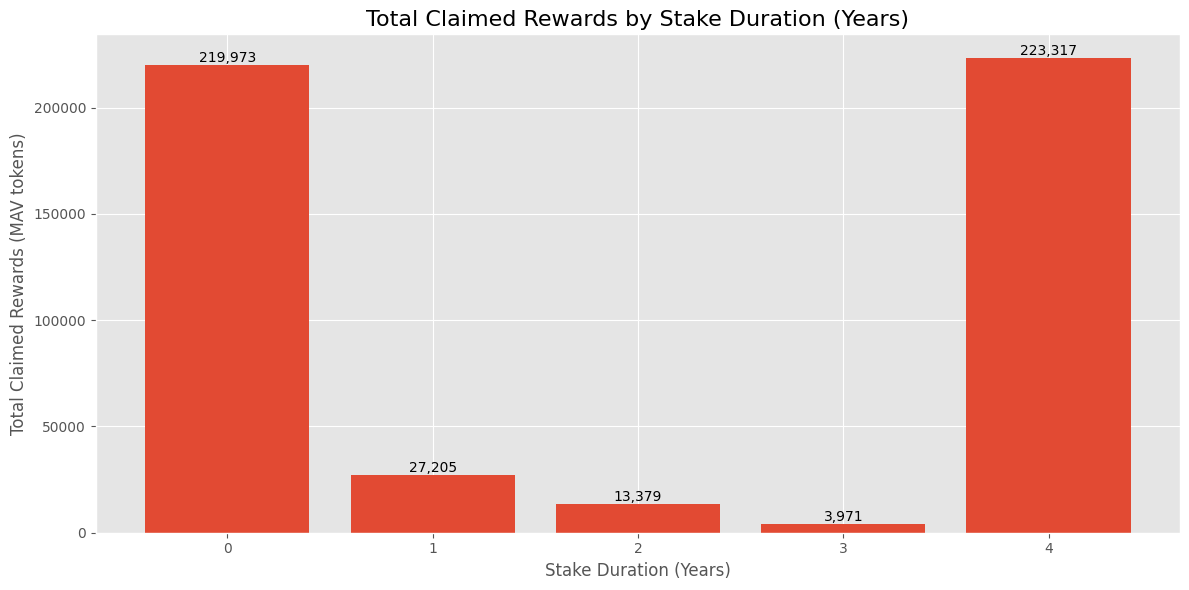

In [179]:
plot(filtered_MaverickV2Reward_df
     , 'stakeDuration'
     , 'rewardOutput_amount'
     , 'Total Claimed Rewards by Stake Duration (Years)'
     , 'Stake Duration (Years)'
     , 'Total Claimed Rewards (MAV tokens)'
)

In [180]:
filtered_MaverickV2Reward_df_copy = filtered_MaverickV2Reward_df.copy() 
# Iterate through stakeDuration values from 0 to 4
for i in range(5):
    # Create a boolean mask for rows where stakeDuration equals i
    mask = filtered_MaverickV2Reward_df_copy['stakeDuration'] == i

    # Use .loc to modify the DataFrame in place
    filtered_MaverickV2Reward_df_copy.loc[mask, 'rewardOutput_amount'] *= (5-i)

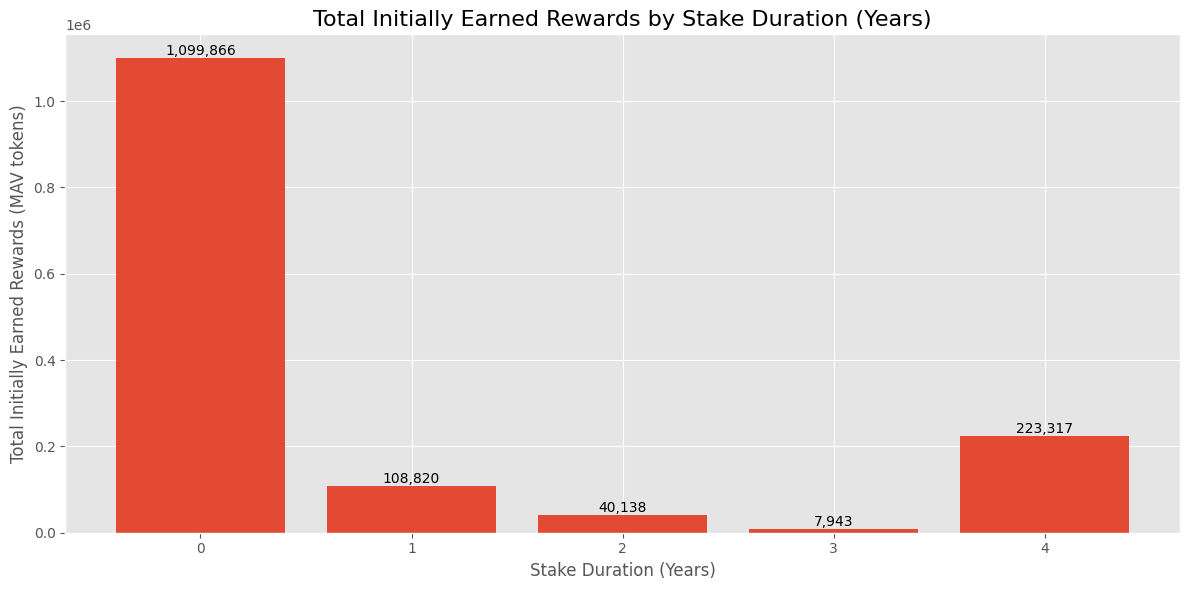

In [181]:
plot(filtered_MaverickV2Reward_df_copy
     , 'stakeDuration'
     , 'rewardOutput_amount'
     , 'Total Initially Earned Rewards by Stake Duration (Years)'
     , 'Stake Duration (Years)'
     , 'Total Initially Earned Rewards (MAV tokens)'
)


## Distributed rewards (with "Distribute()" event)

In [187]:
MaverickV2IncentiveMatcher_contract_addresses = [
    ['new', 'arbitrum-mainnet', '0xB1F334176AadC61F74afc6381210e8786CcEc37D'],
    ['new', 'base-mainnet', '0xc84bDDC0C45FEeFB0F59e1c48332E4d47e29D112'],
    ['new', 'mainnet', '0x9172a390Cb35a15a890293f59EA5aF250b234D55'],
    # Not including BSC & Scroll as explained in the Scope & Assumptions section
    #['new', 'bsc-mainnet', '0x053D0eC15e60c7D8936Ab966A82BB62cCb7E3Ced'], 
    ['new', 'zksync-mainnet', '0x57FA162aCb48376455c5Ff4D45FE0d36E947D79b'],
    #['new', 'scroll-mainnet', ''],
    ['old', 'arbitrum-mainnet', '0xa171Cdc046d0B1Eb87a3E184b5F96B38dA4eC51d'],
    ['old','base-mainnet', '0xc39e8988D7acAC98Ece66d3d0E1e6b9AC5E2624E'],
    ['old','mainnet', '0xC2aFEB5AEf39A89DDcf8f9A93db7bb256F7a5190'],
    #['old','bsc-mainnet', '0x0EDa7a1035E69C0fA9b50E41f9fCE367e36CEBC9'],
    ['old','zksync-mainnet', '0x3D837D468d32dFB1B98ab004A348040B759d485c'],
]

MaverickV2IncentiveMatcher_abis = {
        'new': 
            '[{"inputs":[],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[{"internalType":"address","name":"target","type":"address"}],"name":"AddressEmptyCode","type":"error"},{"inputs":[{"internalType":"address","name":"account","type":"address"}],"name":"AddressInsufficientBalance","type":"error"},{"inputs":[],"name":"FailedInnerCall","type":"error"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"},{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"}],"name":"IncentiveMatcherEpochAlreadyDistributed","type":"error"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"IncentiveMatcherEpochHasEnded","type":"error"},{"inputs":[{"internalType":"uint256","name":"currentTime","type":"uint256"},{"internalType":"uint256","name":"epochEnd","type":"uint256"}],"name":"IncentiveMatcherEpochHasNotEnded","type":"error"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"IncentiveMatcherInvalidEpoch","type":"error"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"lastReward","type":"address"},{"internalType":"contract IMaverickV2Reward","name":"voteReward","type":"address"}],"name":"IncentiveMatcherInvalidTargetOrder","type":"error"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"internalType":"uint256","name":"voteWeights","type":"uint256"},{"internalType":"uint256","name":"totalVoteWeight","type":"uint256"},{"internalType":"uint256","name":"vote","type":"uint256"}],"name":"IncentiveMatcherInvalidVote","type":"error"},{"inputs":[{"internalType":"address","name":"matcher","type":"address"},{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"IncentiveMatcherMatcherAlreadyVetoed","type":"error"},{"inputs":[{"internalType":"address","name":"user","type":"address"},{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"IncentiveMatcherMatcherHasNoBudget","type":"error"},{"inputs":[{"internalType":"address","name":"caller","type":"address"},{"internalType":"address","name":"permissionedCaller","type":"address"}],"name":"IncentiveMatcherNotPermissionedCaller","type":"error"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"}],"name":"IncentiveMatcherNotRewardFactoryContract","type":"error"},{"inputs":[],"name":"IncentiveMatcherRewardDoesNotHaveVeStakingOption","type":"error"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"},{"internalType":"address","name":"matcher","type":"address"},{"internalType":"contract IERC20","name":"token","type":"address"}],"name":"IncentiveMatcherRewardInvalidIncentiveToken","type":"error"},{"inputs":[],"name":"IncentiveMatcherSenderHasAlreadyVoted","type":"error"},{"inputs":[{"internalType":"address","name":"voter","type":"address"},{"internalType":"uint256","name":"voteSnapshotTimestamp","type":"uint256"}],"name":"IncentiveMatcherSenderHasNoVotingPower","type":"error"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"IncentiveMatcherTokenMultipliersAlreadySet","type":"error"},{"inputs":[{"internalType":"uint256","name":"currentTime","type":"uint256"},{"internalType":"uint256","name":"voteEnd","type":"uint256"}],"name":"IncentiveMatcherVetoPeriodHasNotEnded","type":"error"},{"inputs":[{"internalType":"uint256","name":"currentTime","type":"uint256"},{"internalType":"uint256","name":"vetoStart","type":"uint256"},{"internalType":"uint256","name":"vetoEnd","type":"uint256"}],"name":"IncentiveMatcherVetoPeriodNotActive","type":"error"},{"inputs":[{"internalType":"uint256","name":"currentTime","type":"uint256"},{"internalType":"uint256","name":"voteStart","type":"uint256"},{"internalType":"uint256","name":"voteEnd","type":"uint256"}],"name":"IncentiveMatcherVotePeriodNotActive","type":"error"},{"inputs":[],"name":"IncentiveMatcherZeroAmount","type":"error"},{"inputs":[],"name":"MathOverflowedMulDiv","type":"error"},{"inputs":[],"name":"ReentrancyGuardReentrantCall","type":"error"},{"inputs":[{"internalType":"uint8","name":"bits","type":"uint8"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"SafeCastOverflowedUintDowncast","type":"error"},{"inputs":[{"internalType":"address","name":"token","type":"address"}],"name":"SafeERC20FailedOperation","type":"error"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint256","name":"epoch","type":"uint256"},{"indexed":true,"internalType":"address","name":"matcher","type":"address"},{"indexed":false,"internalType":"uint256","name":"matchAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"voteAmount","type":"uint256"}],"name":"BudgetAdded","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"matcher","type":"address"},{"indexed":false,"internalType":"uint256","name":"matchRolloverAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"voteRolloverAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"matchedEpoch","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"newEpoch","type":"uint256"}],"name":"BudgetRolledOver","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint256","name":"epoch","type":"uint256"},{"indexed":true,"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"indexed":true,"internalType":"address","name":"matcher","type":"address"},{"indexed":false,"internalType":"contract IERC20","name":"_baseToken","type":"address"},{"indexed":false,"internalType":"uint256","name":"totalMatch","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"voteMatch","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"incentiveMatch","type":"uint256"}],"name":"Distribute","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint256","name":"epoch","type":"uint256"},{"indexed":true,"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"}],"name":"IncentiveAdded","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint256","name":"epoch","type":"uint256"},{"indexed":true,"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"},{"indexed":false,"internalType":"contract IERC20","name":"token","type":"address"}],"name":"NonBaseTokenIncentiveAdded","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint256","name":"epoch","type":"uint256"},{"indexed":true,"internalType":"address","name":"matcher","type":"address"},{"indexed":true,"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"indexed":false,"internalType":"uint256","name":"nonBaseAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"adjustedAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"tokenMultiplierIndex","type":"uint256"},{"indexed":false,"internalType":"contract IERC20","name":"token","type":"address"}],"name":"NonBaseTokenIncentiveApplied","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint256","name":"epoch","type":"uint256"},{"indexed":true,"internalType":"address","name":"matcher","type":"address"},{"components":[{"internalType":"contract IERC20","name":"token","type":"address"},{"internalType":"uint256","name":"multiplier","type":"uint256"}],"indexed":false,"internalType":"struct IMaverickV2IncentiveMatcher.TokenMultiplier[]","name":"tokenMultipliers","type":"tuple[]"}],"name":"SetTokenMultipliers","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint256","name":"epoch","type":"uint256"},{"indexed":true,"internalType":"address","name":"matcher","type":"address"},{"indexed":true,"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"indexed":false,"internalType":"uint256","name":"voteProductDeduction","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"externalIncentivesDeduction","type":"uint256"}],"name":"Veto","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint256","name":"epoch","type":"uint256"},{"indexed":true,"internalType":"address","name":"voter","type":"address"},{"indexed":true,"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"indexed":false,"internalType":"uint256","name":"vote","type":"uint256"}],"name":"Vote","type":"event"},{"inputs":[],"name":"EPOCH_PERIOD","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"NOTIFY_PERIOD","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"PRE_VOTE_PERIOD","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"VETO_PERIOD","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"},{"internalType":"uint256","name":"startIndex","type":"uint256"},{"internalType":"uint256","name":"endIndex","type":"uint256"}],"name":"activeRewards","outputs":[{"components":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"components":[{"internalType":"uint128","name":"votes","type":"uint128"},{"internalType":"uint128","name":"voteProduct","type":"uint128"},{"internalType":"uint128","name":"externalIncentives","type":"uint128"},{"internalType":"bool","name":"tracked","type":"bool"}],"internalType":"struct IMaverickV2IncentiveMatcher.EpochInformation","name":"rewardInformation","type":"tuple"}],"internalType":"struct IMaverickV2IncentiveMatcher.RewardData[]","name":"returnElements","type":"tuple[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"activeRewardsCount","outputs":[{"internalType":"uint256","name":"count","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"internalType":"uint128","name":"amount","type":"uint128"},{"internalType":"uint256","name":"_duration","type":"uint256"}],"name":"addIncentives","outputs":[{"internalType":"uint256","name":"duration","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint128","name":"matchBudget","type":"uint128"},{"internalType":"uint128","name":"voteBudget","type":"uint128"},{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"addMatchingBudget","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"internalType":"uint128","name":"amount","type":"uint128"},{"internalType":"uint256","name":"_duration","type":"uint256"},{"internalType":"contract IERC20","name":"token","type":"address"}],"name":"addNonBaseTokenIncentives","outputs":[{"internalType":"uint256","name":"duration","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"internalType":"address","name":"matcher","type":"address"},{"internalType":"uint256","name":"tokenMultiplierIndex","type":"uint256"},{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"applyNonBaseTokenMatch","outputs":[{"internalType":"uint128","name":"adjustedAmount","type":"uint128"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"baseToken","outputs":[{"internalType":"contract IERC20","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"checkpointData","outputs":[{"internalType":"uint128","name":"matchBudget","type":"uint128"},{"internalType":"uint128","name":"voteBudget","type":"uint128"},{"components":[{"internalType":"uint128","name":"votes","type":"uint128"},{"internalType":"uint128","name":"voteProduct","type":"uint128"},{"internalType":"uint128","name":"externalIncentives","type":"uint128"},{"internalType":"bool","name":"tracked","type":"bool"}],"internalType":"struct IMaverickV2IncentiveMatcher.EpochInformation","name":"epochTotals","type":"tuple"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"},{"internalType":"address","name":"matcher","type":"address"}],"name":"checkpointMatcherBudget","outputs":[{"internalType":"uint128","name":"matchBudget","type":"uint128"},{"internalType":"uint128","name":"voteBudget","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"},{"internalType":"address","name":"matcher","type":"address"}],"name":"checkpointMatcherData","outputs":[{"components":[{"internalType":"uint128","name":"matchBudget","type":"uint128"},{"internalType":"uint128","name":"voteBudget","type":"uint128"},{"internalType":"uint128","name":"externalIncentivesDeduction","type":"uint128"},{"internalType":"uint128","name":"voteProductDeduction","type":"uint128"},{"internalType":"uint128","name":"nonBaseExternalIncentives","type":"uint128"},{"internalType":"uint128","name":"nonBaseVoteProduct","type":"uint128"},{"components":[{"internalType":"contract IERC20","name":"token","type":"address"},{"internalType":"uint256","name":"multiplier","type":"uint256"}],"internalType":"struct IMaverickV2IncentiveMatcher.TokenMultiplier[]","name":"tokenMultipliers","type":"tuple[]"}],"internalType":"struct IMaverickV2IncentiveMatcher.MatcherData","name":"matcherData","type":"tuple"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"},{"internalType":"contract IERC20[]","name":"tokens","type":"address[]"},{"internalType":"contract IMaverickV2Reward[]","name":"rewardContracts","type":"address[]"}],"name":"checkpointNonBaseIncentiveInfo","outputs":[{"components":[{"internalType":"contract IERC20","name":"token","type":"address"},{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"internalType":"uint256","name":"incentiveAmount","type":"uint256"}],"internalType":"struct IMaverickV2IncentiveMatcher.NonBaseIncentives[]","name":"nonBaseIncentives","type":"tuple[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"},{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"}],"name":"checkpointRewardData","outputs":[{"components":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"components":[{"internalType":"uint128","name":"votes","type":"uint128"},{"internalType":"uint128","name":"voteProduct","type":"uint128"},{"internalType":"uint128","name":"externalIncentives","type":"uint128"},{"internalType":"bool","name":"tracked","type":"bool"}],"internalType":"struct IMaverickV2IncentiveMatcher.EpochInformation","name":"rewardInformation","type":"tuple"}],"internalType":"struct IMaverickV2IncentiveMatcher.RewardData","name":"rewardData","type":"tuple"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"currentEpoch","outputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"internalType":"address","name":"matcher","type":"address"},{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"distribute","outputs":[{"internalType":"uint256","name":"totalMatch","type":"uint256"},{"internalType":"uint256","name":"incentiveMatch","type":"uint256"},{"internalType":"uint256","name":"voteMatch","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"epochEnd","outputs":[{"internalType":"uint256","name":"end","type":"uint256"}],"stateMutability":"pure","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"epochIsOver","outputs":[{"internalType":"bool","name":"isOver","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"},{"internalType":"address","name":"matcher","type":"address"}],"name":"getRolloverBudget","outputs":[{"internalType":"uint256","name":"matchRolloverAmount","type":"uint256"},{"internalType":"uint256","name":"voteRolloverAmount","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"matcher","type":"address"},{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"hasDistributed","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"matcher","type":"address"},{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"hasVetoed","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"user","type":"address"},{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"hasVoted","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"isEpoch","outputs":[{"internalType":"bool","name":"_isEpoch","type":"bool"}],"stateMutability":"pure","type":"function"},{"inputs":[],"name":"lastEpoch","outputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"},{"internalType":"uint256","name":"startIndex","type":"uint256"},{"internalType":"uint256","name":"endIndex","type":"uint256"}],"name":"matchers","outputs":[{"internalType":"address[]","name":"returnElements","type":"address[]"},{"components":[{"internalType":"uint128","name":"matchBudget","type":"uint128"},{"internalType":"uint128","name":"voteBudget","type":"uint128"},{"internalType":"uint128","name":"externalIncentivesDeduction","type":"uint128"},{"internalType":"uint128","name":"voteProductDeduction","type":"uint128"},{"internalType":"uint128","name":"nonBaseExternalIncentives","type":"uint128"},{"internalType":"uint128","name":"nonBaseVoteProduct","type":"uint128"},{"components":[{"internalType":"contract IERC20","name":"token","type":"address"},{"internalType":"uint256","name":"multiplier","type":"uint256"}],"internalType":"struct IMaverickV2IncentiveMatcher.TokenMultiplier[]","name":"tokenMultipliers","type":"tuple[]"}],"internalType":"struct IMaverickV2IncentiveMatcher.MatcherData[]","name":"matcherData","type":"tuple[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"matchersCount","outputs":[{"internalType":"uint256","name":"count","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bytes[]","name":"data","type":"bytes[]"}],"name":"multicall","outputs":[{"internalType":"bytes[]","name":"results","type":"bytes[]"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"internalType":"uint128","name":"amount","type":"uint128"},{"internalType":"contract IERC20","name":"token","type":"address"}],"name":"permissionedAddIncentives","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"permissionedCaller","outputs":[{"internalType":"contract IMaverickV2IncentiveMatcherCaller","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"rewardFactory","outputs":[{"internalType":"contract IMaverickV2RewardFactory","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"}],"name":"rewardHasVeCheck","outputs":[],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"matchedEpoch","type":"uint256"},{"internalType":"uint256","name":"newEpoch","type":"uint256"}],"name":"rolloverExcessBudget","outputs":[{"internalType":"uint256","name":"matchRolloverAmount","type":"uint256"},{"internalType":"uint256","name":"voteRolloverAmount","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"components":[{"internalType":"contract IERC20","name":"token","type":"address"},{"internalType":"uint256","name":"multiplier","type":"uint256"}],"internalType":"struct IMaverickV2IncentiveMatcher.TokenMultiplier[]","name":"_tokenMultipliers","type":"tuple[]"},{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"setTokenMultipliers","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"veToken","outputs":[{"internalType":"contract IMaverickV2VotingEscrow","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"}],"name":"veto","outputs":[{"internalType":"uint128","name":"voteProductDeduction","type":"uint128"},{"internalType":"uint128","name":"externalIncentivesDeduction","type":"uint128"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"vetoingEnd","outputs":[{"internalType":"uint256","name":"end","type":"uint256"}],"stateMutability":"pure","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"vetoingIsActive","outputs":[{"internalType":"bool","name":"isActive","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"vetoingIsOver","outputs":[{"internalType":"bool","name":"isOver","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IMaverickV2Reward[]","name":"voteTargets","type":"address[]"},{"internalType":"uint256[]","name":"weights","type":"uint256[]"}],"name":"vote","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"votingIsActive","outputs":[{"internalType":"bool","name":"isActive","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"votingStart","outputs":[{"internalType":"uint256","name":"start","type":"uint256"}],"stateMutability":"pure","type":"function"}]'
        , 
        'old':
            '[{"inputs":[],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[{"internalType":"address","name":"target","type":"address"}],"name":"AddressEmptyCode","type":"error"},{"inputs":[{"internalType":"address","name":"account","type":"address"}],"name":"AddressInsufficientBalance","type":"error"},{"inputs":[],"name":"FailedInnerCall","type":"error"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"},{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"}],"name":"IncentiveMatcherEpochAlreadyDistributed","type":"error"},{"inputs":[{"internalType":"uint256","name":"currentTime","type":"uint256"},{"internalType":"uint256","name":"epochEnd","type":"uint256"}],"name":"IncentiveMatcherEpochHasNotEnded","type":"error"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"IncentiveMatcherEpochHasPassed","type":"error"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"IncentiveMatcherInvalidEpoch","type":"error"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"lastReward","type":"address"},{"internalType":"contract IMaverickV2Reward","name":"voteReward","type":"address"}],"name":"IncentiveMatcherInvalidTargetOrder","type":"error"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"internalType":"uint256","name":"voteWeights","type":"uint256"},{"internalType":"uint256","name":"totalVoteWeight","type":"uint256"},{"internalType":"uint256","name":"vote","type":"uint256"}],"name":"IncentiveMatcherInvalidVote","type":"error"},{"inputs":[{"internalType":"address","name":"matcher","type":"address"},{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"IncentiveMatcherMatcherAlreadyVetoed","type":"error"},{"inputs":[{"internalType":"address","name":"user","type":"address"},{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"IncentiveMatcherMatcherHasNoBudget","type":"error"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"}],"name":"IncentiveMatcherNotRewardFactoryContract","type":"error"},{"inputs":[{"internalType":"address","name":"matcher","type":"address"},{"internalType":"uint256","name":"matchedEpoch","type":"uint256"}],"name":"IncentiveMatcherNothingToRollover","type":"error"},{"inputs":[],"name":"IncentiveMatcherRewardDoesNotHaveVeStakingOption","type":"error"},{"inputs":[],"name":"IncentiveMatcherSenderHasAlreadyVoted","type":"error"},{"inputs":[{"internalType":"address","name":"voter","type":"address"},{"internalType":"uint256","name":"voteSnapshotTimestamp","type":"uint256"}],"name":"IncentiveMatcherSenderHasNoVotingPower","type":"error"},{"inputs":[{"internalType":"uint256","name":"currentTime","type":"uint256"},{"internalType":"uint256","name":"voteEnd","type":"uint256"}],"name":"IncentiveMatcherVetoPeriodHasNotEnded","type":"error"},{"inputs":[{"internalType":"uint256","name":"currentTime","type":"uint256"},{"internalType":"uint256","name":"vetoStart","type":"uint256"},{"internalType":"uint256","name":"vetoEnd","type":"uint256"}],"name":"IncentiveMatcherVetoPeriodNotActive","type":"error"},{"inputs":[{"internalType":"uint256","name":"currentTime","type":"uint256"},{"internalType":"uint256","name":"voteStart","type":"uint256"},{"internalType":"uint256","name":"voteEnd","type":"uint256"}],"name":"IncentiveMatcherVotePeriodNotActive","type":"error"},{"inputs":[],"name":"IncentiveMatcherZeroBudgetAmount","type":"error"},{"inputs":[],"name":"MathOverflowedMulDiv","type":"error"},{"inputs":[],"name":"ReentrancyGuardReentrantCall","type":"error"},{"inputs":[{"internalType":"uint8","name":"bits","type":"uint8"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"SafeCastOverflowedUintDowncast","type":"error"},{"inputs":[{"internalType":"address","name":"token","type":"address"}],"name":"SafeERC20FailedOperation","type":"error"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"matcher","type":"address"},{"indexed":false,"internalType":"uint256","name":"matchAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"voteAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"BudgetAdded","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"matcher","type":"address"},{"indexed":false,"internalType":"uint256","name":"matchRolloverAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"voteRolloverAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"matchedEpoch","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"newEpoch","type":"uint256"}],"name":"BudgetRolledOver","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"epoch","type":"uint256"},{"indexed":false,"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"indexed":false,"internalType":"address","name":"matcher","type":"address"},{"indexed":false,"internalType":"contract IERC20","name":"_baseToken","type":"address"},{"indexed":false,"internalType":"uint256","name":"totalMatch","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"voteMatch","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"incentiveMatch","type":"uint256"}],"name":"Distribute","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"epoch","type":"uint256"},{"indexed":false,"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"indexed":false,"internalType":"uint256","name":"duration","type":"uint256"}],"name":"IncentiveAdded","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"matcher","type":"address"},{"indexed":false,"internalType":"uint256","name":"epoch","type":"uint256"},{"indexed":false,"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"indexed":false,"internalType":"uint256","name":"voteProductDeduction","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"externalIncentivesDeduction","type":"uint256"}],"name":"Veto","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"voter","type":"address"},{"indexed":false,"internalType":"uint256","name":"epoch","type":"uint256"},{"indexed":false,"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"indexed":false,"internalType":"uint256","name":"vote","type":"uint256"}],"name":"Vote","type":"event"},{"inputs":[],"name":"EPOCH_PERIOD","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"NOTIFY_PERIOD","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"PRE_VOTE_PERIOD","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"VETO_PERIOD","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"},{"internalType":"uint256","name":"startIndex","type":"uint256"},{"internalType":"uint256","name":"endIndex","type":"uint256"}],"name":"activeRewards","outputs":[{"components":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"components":[{"internalType":"uint128","name":"votes","type":"uint128"},{"internalType":"uint128","name":"voteProduct","type":"uint128"},{"internalType":"uint128","name":"externalIncentives","type":"uint128"}],"internalType":"struct IMaverickV2IncentiveMatcher.EpochInformation","name":"rewardInformation","type":"tuple"}],"internalType":"struct IMaverickV2IncentiveMatcher.RewardData[]","name":"returnElements","type":"tuple[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"activeRewardsCount","outputs":[{"internalType":"uint256","name":"count","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"uint256","name":"_duration","type":"uint256"}],"name":"addIncentives","outputs":[{"internalType":"uint256","name":"duration","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint128","name":"matchBudget","type":"uint128"},{"internalType":"uint128","name":"voteBudget","type":"uint128"},{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"addMatchingBudget","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"baseToken","outputs":[{"internalType":"contract IERC20","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"checkpointData","outputs":[{"internalType":"uint128","name":"matchBudget","type":"uint128"},{"internalType":"uint128","name":"voteBudget","type":"uint128"},{"components":[{"internalType":"uint128","name":"votes","type":"uint128"},{"internalType":"uint128","name":"voteProduct","type":"uint128"},{"internalType":"uint128","name":"externalIncentives","type":"uint128"}],"internalType":"struct IMaverickV2IncentiveMatcher.EpochInformation","name":"epochTotals","type":"tuple"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"},{"internalType":"address","name":"matcher","type":"address"}],"name":"checkpointMatcherBudget","outputs":[{"internalType":"uint128","name":"matchBudget","type":"uint128"},{"internalType":"uint128","name":"voteBudget","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"},{"internalType":"address","name":"matcher","type":"address"}],"name":"checkpointMatcherData","outputs":[{"components":[{"internalType":"uint128","name":"matchBudget","type":"uint128"},{"internalType":"uint128","name":"voteBudget","type":"uint128"},{"internalType":"uint128","name":"externalIncentivesDeduction","type":"uint128"},{"internalType":"uint128","name":"voteProductDeduction","type":"uint128"}],"internalType":"struct IMaverickV2IncentiveMatcher.MatcherData","name":"matchAmounts","type":"tuple"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"},{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"}],"name":"checkpointRewardData","outputs":[{"components":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"components":[{"internalType":"uint128","name":"votes","type":"uint128"},{"internalType":"uint128","name":"voteProduct","type":"uint128"},{"internalType":"uint128","name":"externalIncentives","type":"uint128"}],"internalType":"struct IMaverickV2IncentiveMatcher.EpochInformation","name":"rewardInformation","type":"tuple"}],"internalType":"struct IMaverickV2IncentiveMatcher.RewardData","name":"rewardData","type":"tuple"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"currentEpoch","outputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"internalType":"address","name":"matcher","type":"address"},{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"distribute","outputs":[{"internalType":"uint256","name":"totalMatch","type":"uint256"},{"internalType":"uint256","name":"incentiveMatch","type":"uint256"},{"internalType":"uint256","name":"voteMatch","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"epochEnd","outputs":[{"internalType":"uint256","name":"end","type":"uint256"}],"stateMutability":"pure","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"epochIsOver","outputs":[{"internalType":"bool","name":"isOver","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"factory","outputs":[{"internalType":"contract IMaverickV2RewardFactory","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"matcher","type":"address"},{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"hasDistributed","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"matcher","type":"address"},{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"},{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"hasVetoed","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"user","type":"address"},{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"hasVoted","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"isEpoch","outputs":[{"internalType":"bool","name":"_isEpoch","type":"bool"}],"stateMutability":"pure","type":"function"},{"inputs":[],"name":"lastEpoch","outputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"},{"internalType":"uint256","name":"startIndex","type":"uint256"},{"internalType":"uint256","name":"endIndex","type":"uint256"}],"name":"matchers","outputs":[{"internalType":"address[]","name":"returnElements","type":"address[]"},{"components":[{"internalType":"uint128","name":"matchBudget","type":"uint128"},{"internalType":"uint128","name":"voteBudget","type":"uint128"},{"internalType":"uint128","name":"externalIncentivesDeduction","type":"uint128"},{"internalType":"uint128","name":"voteProductDeduction","type":"uint128"}],"internalType":"struct IMaverickV2IncentiveMatcher.MatcherData[]","name":"matchAmounts","type":"tuple[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"matchersCount","outputs":[{"internalType":"uint256","name":"count","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bytes[]","name":"data","type":"bytes[]"}],"name":"multicall","outputs":[{"internalType":"bytes[]","name":"results","type":"bytes[]"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"}],"name":"rewardHasVe","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"matchedEpoch","type":"uint256"},{"internalType":"uint256","name":"newEpoch","type":"uint256"}],"name":"rolloverExcessBudget","outputs":[{"internalType":"uint256","name":"matchRolloverAmount","type":"uint256"},{"internalType":"uint256","name":"voteRolloverAmount","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"veToken","outputs":[{"internalType":"contract IMaverickV2VotingEscrow","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IMaverickV2Reward","name":"rewardContract","type":"address"}],"name":"veto","outputs":[{"internalType":"uint128","name":"voteProductDeduction","type":"uint128"},{"internalType":"uint128","name":"externalIncentivesDeduction","type":"uint128"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"vetoingEnd","outputs":[{"internalType":"uint256","name":"end","type":"uint256"}],"stateMutability":"pure","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"vetoingIsActive","outputs":[{"internalType":"bool","name":"isActive","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"vetoingIsOver","outputs":[{"internalType":"bool","name":"isOver","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IMaverickV2Reward[]","name":"voteTargets","type":"address[]"},{"internalType":"uint256[]","name":"weights","type":"uint256[]"}],"name":"vote","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"votingIsActive","outputs":[{"internalType":"bool","name":"isActive","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"epoch","type":"uint256"}],"name":"votingStart","outputs":[{"internalType":"uint256","name":"start","type":"uint256"}],"stateMutability":"pure","type":"function"}]'
       }

epoch_0 = 1718841600
epoch_length = 1209600


MaverickV2IncentiveMatcher_values = []

for contract_address_ in MaverickV2IncentiveMatcher_contract_addresses:
    old_new = contract_address_[0]
    blockchain = contract_address_[1]
    contract_address = contract_address_[2]
    abi = MaverickV2IncentiveMatcher_abis[old_new]

    contract = get_contract(blockchain, contract_address, abi)
    print(old_new + ' - ' + blockchain)
    logs = contract.events.Distribute().get_logs(fromBlock=1)
    for log in logs:
        epoch = 1 + (log['args']['epoch'] - epoch_0) / epoch_length
        if epoch <= last_epoch:
            MaverickV2IncentiveMatcher_values.append({'blockchain': blockchain
                , 'epoch': epoch
                , '_baseToken': log['args']['_baseToken']
                , 'totalMatch': log['args']['totalMatch']/1e18
                , 'voteMatch': log['args']['voteMatch']/1e18
                , 'incentiveMatch': log['args']['incentiveMatch']/1e18
                , 'NonBaseTokenIncentive': 0
                , 'rewardContract': log['args']['rewardContract']
                }
            )





new - arbitrum-mainnet
new - base-mainnet
new - mainnet
new - zksync-mainnet
old - arbitrum-mainnet
old - base-mainnet
old - mainnet
old - zksync-mainnet


In [188]:
MaverickV2IncentiveMatcher_df = pd.DataFrame(MaverickV2IncentiveMatcher_values)
MaverickV2IncentiveMatcher_df.head()

,blockchain,epoch,_baseToken,totalMatch,voteMatch,incentiveMatch,NonBaseTokenIncentive,rewardContract
0,arbitrum-mainnet,3.0,0x7448c7456a97769F6cD04F1E83A4a23cCdC46aBD,21600.000000,0.000000,21600.000000,0,0x9f4781fC065e2052E75127D4f5D270e2Bb861989
1,arbitrum-mainnet,4.0,0x7448c7456a97769F6cD04F1E83A4a23cCdC46aBD,6715.899756,6667.000000,48.899756,0,0x01546c49Efd87964F39248B5E18fA4806f3A1FA8
2,arbitrum-mainnet,4.0,0x7448c7456a97769F6cD04F1E83A4a23cCdC46aBD,19951.100244,0.000000,19951.100244,0,0x9f4781fC065e2052E75127D4f5D270e2Bb861989
3,arbitrum-mainnet,5.0,0x7448c7456a97769F6cD04F1E83A4a23cCdC46aBD,5366.096315,4366.096315,1000.000000,0,0x76eC462750Ff5c4d8420648F89Ea712Ca6487BC2
4,arbitrum-mainnet,5.0,0x7448c7456a97769F6cD04F1E83A4a23cCdC46aBD,0.536610,0.436610,0.100000,0,0x76eC462750Ff5c4d8420648F89Ea712Ca6487BC2


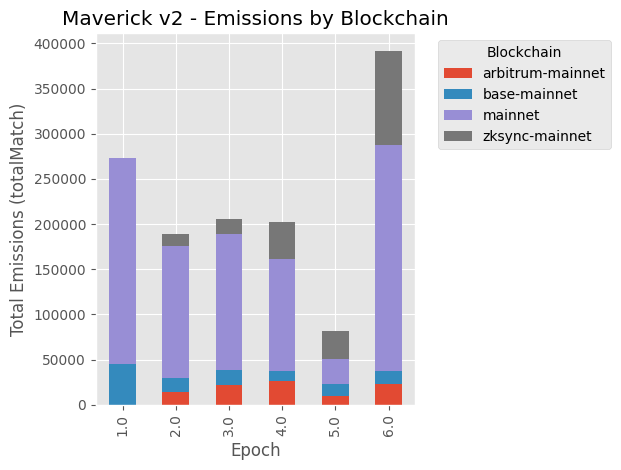

In [189]:
df_grouped = MaverickV2IncentiveMatcher_df.groupby(['epoch', 'blockchain'])['totalMatch'].sum().unstack()

# Plotting
df_grouped.plot(kind='bar', stacked=True)

# Adding labels and title
plt.xlabel("Epoch")
plt.ylabel("Total Emissions (totalMatch)")
plt.title("Maverick v2 - Emissions by Blockchain")
plt.legend(title="Blockchain", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

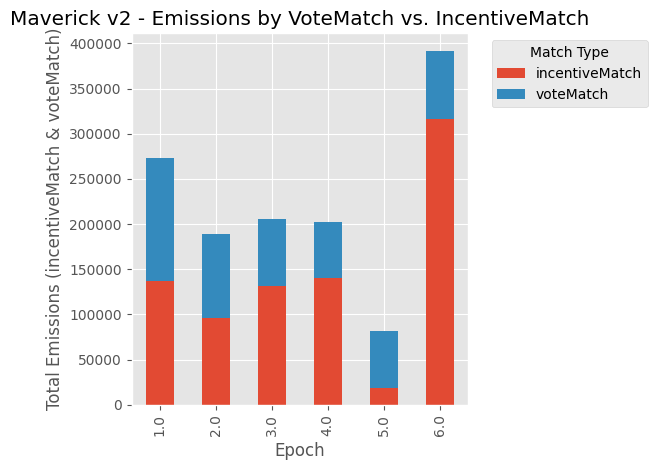

In [190]:
# Group by 'epoch' and sum based on 'incentiveMatch' and 'voteMatch'
df_grouped_v2 = MaverickV2IncentiveMatcher_df.groupby(['epoch'])[['incentiveMatch', 'voteMatch']].sum()

# Plotting
df_grouped_v2.plot(kind='bar', stacked=True)

# Adding labels and title
plt.xlabel("Epoch")
plt.ylabel("Total Emissions (incentiveMatch & voteMatch)")
plt.title("Maverick v2 - Emissions by VoteMatch vs. IncentiveMatch")
plt.legend(title="Match Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()